In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
preprocessing_fp = "preprocessing/combined_filtered"
BATCH_SIZE = 32
EPOCHS = 1
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
LABELS = ["female", "male"]

In [11]:
# Load train dataset
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

# Load validation dataset
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 29026 files belonging to 2 classes.
Found 8275 files belonging to 2 classes.


In [12]:
# Use buffered prefetching to load images without having I/O blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Helpful since we want to expand our image dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
# Load MobileNetV3 Large
preprocess_input_mobile = tf.keras.applications.mobilenet_v3.preprocess_input
base_model_mobile = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Load DenseNet 201
preprocess_input_dense = tf.keras.applications.densenet.preprocess_input
base_model_dense = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Load ResNet50
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
base_model_res = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Model Training

In [19]:
def create_model(base_model, preprocess_input):
    # Converts images into a 5x5x1280 block of features
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    
    # Freeze all convolutional base
    base_model.trainable = False
    
    # Add classification head
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    # Model building
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    outputs = keras.layers.Dense(1,activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [20]:
# Create the three different models
model_mobile = create_model(base_model_mobile, preprocess_input_mobile)
model_dense = create_model(base_model_dense, preprocess_input_dense)
model_res = create_model(base_model_res, preprocess_input_res)

In [21]:
def model_training(model, suffix):
    """
    Trains model, and saves model's best weights and history
    """
    checkpoint = ModelCheckpoint(
        "model_tl_best_weights_{}.h5".format(suffix),
        monitor="loss",
        verbose=0,
        save_best_only=True,
        mode="min",
        save_freq="epoch",
    )

    # Save a checkpoint of the model for later use
    history = model.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=validation_dataset,
                            callbacks=[checkpoint])

    # Store model history as a JSON file
    with open(os.path.join("history", "model_tl_history_{}.json".format(suffix)), "w") as f:
        json.dump(history.history, f) # Construct the baseline (unperturbed) model

In [22]:
# Train each of the models
model_training(model_mobile, 'mobile')
model_training(model_dense, 'dense')
model_training(model_res, 'res')

908/908 [==============================] - 52s 55ms/step - loss: 0.5204 - accuracy: 0.7313 - val_loss: 0.4093 - val_accuracy: 0.8092


# Model Analysis

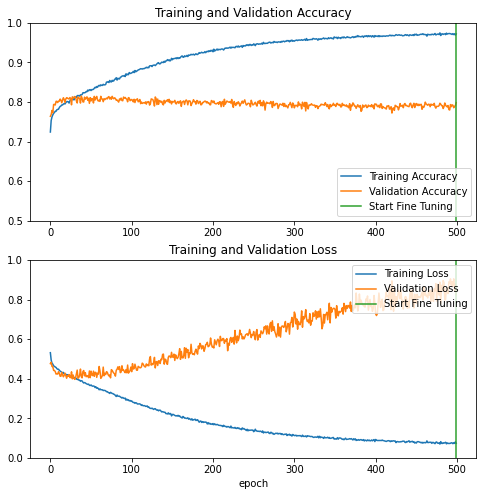

In [25]:
# View model training graph over epochs
with open('history/model_tl_history.json') as f:
    st = json.load(f)

acc = []
val_acc = []
loss = []
val_loss = []

acc += st['accuracy']
val_acc += st['val_accuracy']

loss += st['loss']
val_loss += st['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()